In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 1

import numpy as np
from scipy.integrate import ode

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

%aimport lorenz

# The Kalman filter

The Kalman filter is a procedure to estimate the state of a system with known dynamics, but which can only be observed imperfectly.

Consider everyone's favorite example, the Lorenz attractor:

$\dot x = \sigma(y - x)$

$\dot y = x(\rho - z) - y$

$\dot z = xy - \beta z$

Given an initial condition $[x_0, y_0, z_0]$, we can use our favorite ODE solver to compute the trajectory of this initial condition.

In [2]:
from lorenz import *

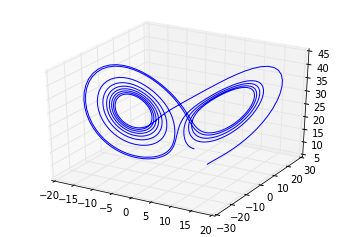

In [6]:
q = lorenz.lorenz([5.0, 5.0, 5.0], 0.0, 10.0)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(q[:,0], q[:,1], q[:,2])

plt.show()

What if we only get to observe the system at discrete time intervals?

What if we don't even get to observe the system, just the output of some sensor?

And what if the sensor makes errors?

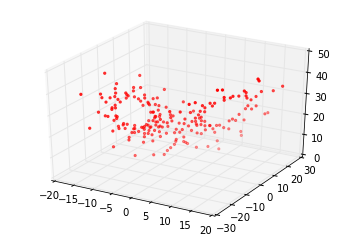

In [17]:
d = lorenz.observational_data

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(d[:,0], d[:,1], d[:,2], color='r', marker='.')

plt.show()

How can we use the (admittedly noisy) observations together with what we know about the underlying system?

# Linear stochastic dynamical systems

Consider a discrete dynamical system

$$x_k = A_kx_{k - 1} + \xi_k.$$

$\xi_k$ is the *process noise*; $\xi_k \sim N(0, C)$.

However, we don't get to observe $x_k$ directly; rather, we only get to see

$$y_k = H_kx_k + \eta_k,$$

where $\eta_k \sim N(0, Q)$ is the *measurement noise*.